# SweetTalk
- first language model for glycans
- analysis of glycan substructures and species distribution
- classifiers for glycan linkage & immunogenicity
- run cells in given order
- easiest way to run notebook is to upload the deposited files to Google Drive

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline  
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import random
import string
import numpy as np
import sys, os
import time, copy
import re
import umap
import seaborn as sns
import heapq
from collections import Counter

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#library for mixed precision training
!pip install git+https://github.com/NVIDIA/apex
from apex import amp

  Cloning https://github.com/NVIDIA/apex to /tmp/pip-req-build-wq97i4dm
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-wq97i4dm
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=137234 sha256=e84f6427190d8fe64e3d86b096f3766b129f99f165daabbaca941ad1740abfe2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0da04yjn/wheels/91/1e/dc/41a5ba86547c578bd19be9cb9bdfd90b4e797acc58377e343b
Successfully built apex


# Helper Functions for Glycan Processing

In [0]:
def motif_find(s):
  """converts a IUPACcondensed-ish glycan into a list of overlapping, asterisk-separated glycowords"""
  b = s.split('(')
  b = [k.split(')') for k in b]
  b = [item for sublist in b for item in sublist]
  b = [k.strip('[') for k in b]
  b = [k.strip(']') for k in b]
  b = [k.replace('[', '') for k in b]
  b = [k.replace(']', '') for k in b]
  b = ['*'.join(b[i:i+5]) for i in range(0, len(b)-4, 2)]
  return b

def small_motif_find(s):
  """converts a IUPACcondensed-ish glycan into an asterisk-separated string of glycoletters"""
  b = s.split('(')
  b = [k.split(')') for k in b]
  b = [item for sublist in b for item in sublist]
  b = [k.strip('[') for k in b]
  b = [k.strip(']') for k in b]
  b = [k.replace('[', '') for k in b]
  b = [k.replace(']', '') for k in b]
  b = '*'.join(b)
  return b

def process_glycans(glycan_list):
  """converts list of glycans into a list of lists of glycowords"""
  glycan_motifs = [motif_find(k) for k in glycan_list]
  glycan_motifs = [[i.split('*') for i in k] for k in glycan_motifs]
  return glycan_motifs

def motif_find_mutate(s, mutate = True, n_mut = 1, mode = 'normal'):
  """takes a glycan and samples generated mutants (sort-of-overkill for single mutants as exhaustive mutation is quicker)"""
  b = s.split('(')
  b = [k.split(')') for k in b]
  b = [item for sublist in b for item in sublist]
  b = [k.strip('[') for k in b]
  b = [k.strip(']') for k in b]
  b = [k.replace('[', '') for k in b]
  b = [k.replace(']', '') for k in b]
  if mutate:
    for i in range(n_mut):
      idx = random.choice(range(len(b)))
      if idx % 2 == 0:
        if mode == 'normal':
          b[idx] = random.choice(sugars)
        elif mode == 'extreme':
          b[idx] = random.choice(all_sugars)
      else:
        if mode == 'normal':
          b[idx] = random.choice(bonds)
        elif mode == 'extreme':
          b[idx] = random.choice(all_bonds)
  b_label = '*'.join(b)
  b = ['*'.join(b[i:i+5]) for i in range(0, len(b)-4, 2)]
  return b, b_label

def process_mutated_glycans(glycan, n_mut = 1, n = 2000, mode = 'normal'):
  """converts one glycan into a list of WT + n mutated glycans and their glycowords"""
  wt, wt_label = motif_find_mutate(glycan, mutate = False)
  wt = [i.split('*') for i in wt]
  glycan_motifs, glycan_labels = zip(*[motif_find_mutate(glycan, n_mut = n_mut, mode = mode) for k in range(n)])
  glycan_motifs = [[i.split('*') for i in k] for k in glycan_motifs]
  out = [wt] + list(glycan_motifs)
  out_labels = [wt_label] + list(glycan_labels)
  return out, out_labels

def targetify(df):
  """sort of legacy function, converts UniCarbKB/PubChem strings into glycan sequence and linkage label"""
  olink = []
  nlink = []
  free = []
  seqs = []
  for k in df:
		#k=k[0]
    if 'O_' in k:
      olink.append(1)
      nlink.append(0)
      free.append(0)
    elif 'N_' in k:
      olink.append(0)
      nlink.append(1)
      free.append(0)
    elif 'F_' in k:
      olink.append(0)
      nlink.append(0)
      free.append(1)
    else:
      olink.append(0)
      nlink.append(0)
      free.append(0)
    temp = k.split(';')
    temp = [i for i in temp if '_' not in i]
    seqs.append(temp[0].strip())
  out = list(zip(seqs, olink, nlink, free))
  out = pd.DataFrame(out, columns = ['seq', 'olink', 'nlink','free'])
  return out

# Preparing Dataset for Pre-Training

In [0]:
#all glycans containing at least one glycoword
#corresponds to Supplementary Table 2
df_all = pd.read_csv('drive/My Drive/combined_database_long.csv').target.values.tolist()
df_all = process_glycans(df_all)
df_all = [item for sublist in df_all for item in sublist]

#make library of all observed glycowords
lib_all = list(sorted(list(set([item for sublist in df_all for item in sublist]))))
lib_size_all = len(lib_all)

# Tokenization Helper Functions

In [0]:
def character_to_label(character, libr):
  """tokenizes character by indexing passed library"""
  character_label = libr.index(character)
  return character_label

def string_to_labels(character_string, libr):
  """tokenizes word by indexing characters in passed library"""
  return list(map(lambda character: character_to_label(character, libr), character_string))

def pad_sequence(seq, max_length, pad_label = lib_size_all):
  """adds padding as a new label"""
  seq += [pad_label for i in range(max_length-len(seq))]
  return seq

In [0]:
#dataset class for language models, handles tokenization and padding if true
class SugarDataset(data.Dataset):
  def __init__(self, df, libr, libr_size = lib_size_all, padding = False):
    self.df = df
    self.libr = libr
    self.libr_size = libr_size
    self.padding = padding
    self.max_len = len(max(self.df, key = len))
    self.idx = range(len(self.df)) 
    
  def __len__(self):
    return len(self.idx)
  
  def __getitem__(self, index):
    index = self.idx[index]
    raw_string = self.df[index]
    string_labels = string_to_labels(raw_string, self.libr)
    seq_length = len(string_labels)-1
    
    input_string_labels = string_labels[:-1]
    output_string_labels = string_labels[1:]

    if self.padding:
      input_string_labels = pad_sequence(input_string_labels, max_length = self.max_len, pad_label = self.libr_size)
      output_string_labels = pad_sequence(output_string_labels, max_length = self.max_len, pad_label = self.libr_size)
    
    return (torch.LongTensor(input_string_labels),
           torch.LongTensor(output_string_labels),
           torch.LongTensor([seq_length]))

#this will increase efficiency, as sequences with similar padding lengths will be grouped together in minibatches, avoiding wasteful computation
def post_process_sequence_batch(batch_tuple):
    input_seq, output_seq, seq_length = batch_tuple
    split_input_seq_batch = input_seq.split(split_size = 1)
    split_output_seq_batch = output_seq.split(split_size = 1)
    split_length_batch = seq_length.split(split_size = 1)
    
    train_data_tuples = zip(split_input_seq_batch,
                         split_output_seq_batch,
                         split_length_batch)
    sorted_train_data = sorted(train_data_tuples,
                            key = lambda p:int(p[2]),
                            reverse = True)
    split_input_batch, split_output_batch, split_length_batch = zip(*sorted_train_data)
    input_seq_sorted = torch.cat(split_input_batch)
    output_seq_sorted = torch.cat(split_output_batch)
    length_sorted = torch.cat(split_length_batch)
    
    input_seq_sorted = input_seq_sorted[:, :length_sorted[0,0]]
    output_seq_sorted = output_seq_sorted[:, :length_sorted[0,0]]
    
    input_seq_transposed = input_seq_sorted.transpose(0,1)
    
    length_sorted_list = list(length_sorted)
    length_sorted_list = list(map(lambda x: int(x), length_sorted_list))
    
    return input_seq_transposed, output_seq_sorted, length_sorted_list

#Prepare Data for Pre-Training

In [0]:
#convert glycowords into a true character-based situation and create the corresponding library
df2_char = [list(''.join(k)) for k in df_all]
lib_char = list(sorted(list(set([item for sublist in df2_char for item in sublist]))))
lib_size_char = len(lib_char)
train_char, val_char = train_test_split(df2_char, test_size = 0.2, shuffle = True)

#create datasets & dataloaders for model training
trainset_char = SugarDataset(train_char, lib_char, libr_size = lib_size_char, padding = True)
trainset_loader_char = data.DataLoader(trainset_char, batch_size = 256,
                               shuffle = True, num_workers=0, pin_memory = True)

valset_char = SugarDataset(val_char, lib_char, libr_size = lib_size_char, padding = True)
valset_loader_char = data.DataLoader(valset_char, batch_size = 64,
                             shuffle = False)

dataloaders = {'train':trainset_loader_char, 'val':valset_loader_char}
dataset_sizes = {'train':len(train_char), 'val':len(val_char)}

# Prepare Model Training

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience = 7, verbose = False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #torch.save(model.state_dict(), 'drive/My Drive/checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25, padding = False):
  """training loop for language models, keeps track of a few metrics"""
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_perplexity = 100.0
  val_losses = []
  val_perplexities = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_perplexity = []
      for inputs, outputs, lengths in dataloaders[phase]:
        if padding:
          post_processed_batch_tuple = post_process_sequence_batch((inputs, outputs, lengths))
          inputs, outputs, lengths = post_processed_batch_tuple
        inputs = inputs.cuda()
        outputs = outputs.contiguous().view(-1).cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred,_ = model(inputs, lengths)
          loss = criterion(pred,outputs)
          if phase == 'train':
            with amp.scale_loss(loss, optimizer) as scaled_loss:
              scaled_loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_perplexity.append(np.exp(loss.item()))
        
      epoch_loss = np.mean(running_loss)
      epoch_perplexity = np.mean(running_perplexity)
      print('{} Loss: {:.4f} Perplexity: {:.4f}'.format(
          phase, epoch_loss, epoch_perplexity))
      
      if phase == 'val' and epoch_perplexity <= best_perplexity:
        best_perplexity = epoch_perplexity
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_perplexities.append(epoch_perplexity)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Perplexity: {:4f}'.format(best_perplexity))
  model.load_state_dict(best_model_wts)

  ## plot loss & perplexity over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of SweetTalk')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'],loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_perplexities)
  plt.ylabel('Validation Perplexity')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation Perplexity'], loc = 'best')
  return model

In [0]:
#bidirectional, two-layered LSTM. Softmax is in the loss function
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, n_layers = 2):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.encoder = nn.Embedding(input_size, hidden_size, padding_idx = self.num_classes-1)
    self.decoder = nn.Linear(hidden_size, num_classes)
    self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = True)
    self.logits_fc = nn.Linear(2*hidden_size, num_classes)   
    
  def forward(self, input_seq, input_seq_len, hidden = None):
    batch_size = input_seq.shape[1]
    self.bn1 = nn.BatchNorm1d(batch_size).cuda()
    embedded = self.bn1(self.encoder(input_seq))
    
    packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_seq_len)
    outputs, (h_n, c_n) = self.gru(packed, hidden)
    outputs, outputs_len = torch.nn.utils.rnn.pad_packed_sequence(outputs)
    
    logits = self.logits_fc(outputs.cuda())
    logits = logits.transpose(0,1).contiguous()
    logits_flatten = logits.view(-1, self.num_classes)
    
    return logits_flatten, hidden

# Pre-Training SweetTalk

In [0]:
#Xavier initialization of fully connected layers
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model=RNN(input_size = lib_size_char+1, hidden_size = 128,
                       num_classes = lib_size_char+1)
model.apply(init_weights)
model.cuda()

early_stopping = EarlyStopping(patience = 10, verbose = True)
optimizer_ft = optim.Adam(model.parameters(), lr = 0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 100)
model, optimizer_ft = amp.initialize(model, optimizer_ft, opt_level = "O1")
criterion = nn.CrossEntropyLoss().cuda()
#model_ft = train_model(model, criterion, optimizer_ft, scheduler,
#                    num_epochs = 150, padding = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [0]:
#torch.save(model_ft, 'drive/My Drive/SweetTalk_large_char.pt')
model_ft = torch.load('drive/My Drive/SweetTalk_large_char.pt').eval()

# Prepare Dataset for Language Model

In [0]:
#all glycans containing at least one glycoword
df_all_long = pd.read_csv('drive/My Drive/combined_database_long.csv').target.values.tolist()
df_all_long = process_glycans(df_all_long)
df_all_long = [item for sublist in df_all_long for item in sublist]

#make library of all observed glycowords
lib_all_long = list(sorted(list(set([item for sublist in df_all_long for item in sublist]))))
lib_size_all_long = len(lib_all_long)

In [0]:
#get trained character embeddings from model
embed_char = model_ft.encoder.weight.data.cpu().numpy()

#construct glycoletter embeddings from character embeddings by averaging
rep = {}
for k in range(len(lib_all_long)):
  query = list(lib_all_long[k])
  query = [lib_char.index(i) for i in query]
  rep[lib_all_long[k]] = np.mean(embed_char[query,:], axis = 0)

#construct initializing embedding for language model by adding a padding embedding
init_emb = np.array(list(rep.values()))
init_emb = np.concatenate([init_emb,np.array([0]*128).reshape(1,-1)])
init_emb.shape

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(603, 128)

# Visualize Trained Glycoletter Embeddings
- as learned by pre-training

In [0]:
#UMAP & t-SNE dimensionality reduction of embeddings
reducer = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb = reducer.fit_transform(init_emb[1:])
tsne_emb = TSNE(n_components = 2).fit_transform(init_emb[1:])

In [0]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s = 100, alpha = 0.5)
for i, txt in enumerate(lib_all_long):
    if random.random() > 0.9:
    #if emb_dist[i] > 0.5*np.max(emb_dist):
      text = plt.annotate(txt, (tsne_emb[:,0][i], tsne_emb[:,1][i]), alpha = 1)
      text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Trained Glycoletter Embeddings')
plt.tight_layout()
#plt.savefig('drive/My Drive/trained_glycoletters_language_large_tsne.svg', format = 'svg', dpi = 300)

# Prepare Data for Language Model Training

In [0]:
train, val = train_test_split(df_all_long, test_size = 0.2, shuffle = True)

trainset = SugarDataset(train, lib_all_long)
trainset_loader = data.DataLoader(trainset, batch_size = 256,
                               shuffle = True, num_workers = 4, pin_memory = True)

valset = SugarDataset(val, lib_all_long)
valset_loader = data.DataLoader(valset, batch_size = 64,
                             shuffle = False)

dataloaders = {'train':trainset_loader, 'val':valset_loader}
dataset_sizes = {'train':len(train), 'val':len(val)}

In [0]:
#bidirectional, two-layered LSTM without padding
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, n_layers = 2):
    super(RNN,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.encoder = nn.Embedding(input_size, hidden_size, padding_idx = self.num_classes-1)
    self.decoder = nn.Linear(hidden_size, num_classes)
    self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = True)
    self.logits_fc = nn.Linear(2*hidden_size, num_classes)   
    
  def forward(self, input_seq, input_seq_len, hidden = None):
    batch_size = input_seq.shape[1]
    self.bn1 = nn.BatchNorm1d(batch_size).cuda()
    embedded = self.bn1(self.encoder(input_seq))
    
    outputs, (h_n, c_n) = self.gru(embedded,hidden)
    
    logits = self.logits_fc(outputs)
    logits = logits.transpose(0,1).contiguous()
    logits_flatten = logits.view(-1, self.num_classes)
    
    return logits_flatten, hidden

# SweetTalk (Language Model)

In [0]:
model = RNN(input_size = lib_size_all_long, hidden_size = 128,
                       num_classes = lib_size_all_long)
model.apply(init_weights)
model.encoder.weight.data = torch.from_numpy(init_emb[1:]).float()
model.cuda()

early_stopping = EarlyStopping(patience = 10, verbose = True)
optimizer_ft = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 100)
model, optimizer_ft = amp.initialize(model, optimizer_ft, opt_level = "O1")
criterion = nn.CrossEntropyLoss().cuda()
#model_ft = train_model(model, criterion, optimizer_ft, scheduler,
#                    num_epochs = 150)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#torch.save(model_ft, 'drive/My Drive/SweetTalk_large2.pt')
model_ft = torch.load('drive/My Drive/SweetTalk_large2.pt').eval()

# Visualize Trained Glycoletter Embeddings
- as learned by language model

In [0]:
#extract glycoletter embeddings from trained language model
embed = model_ft.encoder.weight.data.cpu().numpy()

#UMAP & t-SNE dimensionality reduction
reducer = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb = reducer.fit_transform(embed)
tsne_emb = TSNE(n_components = 2).fit_transform(embed)

In [0]:
#calculate pairwise distances between glycoletter embeddings from different sources
emb_dist = paired_distances(init_emb[1:], embed)

In [0]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s = 100, alpha = 0.5, c = emb_dist, cmap = 'viridis')
for i, txt in enumerate(lib_all_long):
  #if random.random() > 0.8:
  if emb_dist[i] > 0.5*np.max(emb_dist):
    text = plt.annotate(txt, (tsne_emb[:,0][i], tsne_emb[:,1][i]))
    text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Trained Glycoletter Embeddings')
plt.tight_layout()
#plt.colorbar()
#plt.savefig('drive/My Drive/trained_glycoletters_large_tsne_wo_language.svg', format = 'svg', dpi = 300)

# Constructing New/Artifical Glycoletter Embeddings

In [0]:
def construct_novel(glyc):
  """Function to construct an embedding for any glycoletter composed of characters seen by the model. Also returns the five closest glycoletter embeddings."""
  temp = list(glyc)
  temp = [lib_char.index(i) for i in temp]
  out = np.mean(embed_char[temp,:], axis = 0)
  sims = cosine_similarity(out.reshape(1,-1), embed).tolist()[0]
  sims = heapq.nlargest(5, range(len(sims)), sims.__getitem__)
  out_close = [lib_all_long[k] for k in sims]
  return out, out_close

#construct embeddings for three possible glycoletters not observed in the database
wishlist = ['AraOS', 'XylOMe', 'L-Galf']
wish_emb, wish_emb_close = zip(*[construct_novel(k) for k in wishlist])

In [0]:
#t-SNE dimensionality reduction to visualize artificial glycoletters
tsne_emb = TSNE(n_components = 2).fit_transform(np.concatenate([embed, wish_emb], axis = 0))

In [0]:
fig = plt.figure(figsize = (10,10))
clrs = ['Blue', 'Green', 'Purple']
plt.scatter(tsne_emb[:602,0], tsne_emb[:602,1], s = 100, alpha = 0.5)
plt.scatter(tsne_emb[602:,0], tsne_emb[602:,1], s = 100, alpha = 0.5, c = 'Orange')
for m in range(len(wish_emb_close)):
  for i, txt in enumerate(wish_emb_close[m]):
    k = lib_all_long.index(txt)
    text = plt.annotate(txt, (tsne_emb[:,0][k], tsne_emb[:,1][k]), color = clrs[m])
    text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
for i, txt in enumerate(wishlist):
  text = plt.annotate(txt, (tsne_emb[602:,0][i], tsne_emb[602:,1][i]))
  text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Constructed Glycoletter Embeddings')
plt.tight_layout()
#plt.savefig('drive/My Drive/constructed_glycoletters.svg', format = 'svg', dpi = 300)

# Analyzing Glycan Substructures

In [0]:
#total number of unique glycowords observed in the database
len(list(set([tuple(k) for k in df_all_long])))

8843

In [0]:
#count frequencies of observed glycowords
cou = Counter([tuple(k) for k in df_all_long])

#convert glycowords into lists of glycoletter labels for indexing
words = list(sorted(list(set([tuple(string_to_labels(k, lib_all_long)) for k in df_all_long]))))
words_label = list(sorted(list(set([tuple(k) for k in df_all_long]))))
words[0]

(1, 135, 592, 135, 592)

In [0]:
#construct glycoword embeddings by averaging their glycoletter embeddings
rep = {}
for k in range(len(words)):
  rep[words_label[k]] = np.mean(embed[list(words[k]), :], axis = 0)

In [0]:
#UMAP & t-SNE dimensionality reduction
reducer2 = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb2 = reducer2.fit_transform(pd.DataFrame.from_dict(rep).T)
tsne_emb2 = TSNE(n_components = 2).fit_transform(pd.DataFrame.from_dict(rep).T)

In [0]:
#get sorted glycoword frequencies
freqs = [cou[k] for k in words_label]

Text(0, 0.5, 'Density')

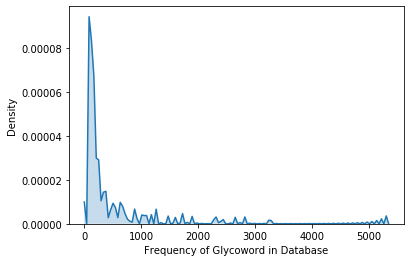

In [0]:
sns.kdeplot(np.array(list(Counter(cou).values())), bw = 0.1, shade = True)
plt.xlabel('Frequency of Glycoword in Database')
plt.ylabel('Density')
#plt.savefig('drive/My Drive/kdeplot_glycowords.svg', format = 'svg', dpi = 300)

Text(0.5, 0, 'Frequency in Database')

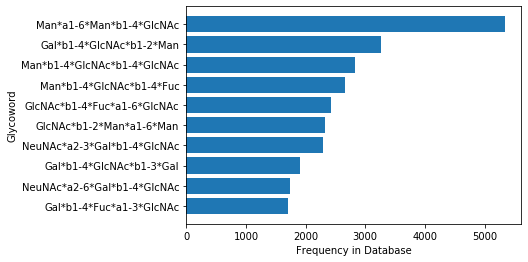

In [0]:
comb = sorted(zip(freqs, words_label), key=lambda x: x[0])
s_freqs, s_words_label = zip(*comb)
s_words_label = ['*'.join(list(k)) for k in s_words_label]
plt.barh(range(10), s_freqs[-10:])
plt.yticks(range(10), s_words_label[-10:])
plt.ylabel('Glycoword')
plt.xlabel('Frequency in Database')
#plt.savefig('drive/My Drive/glycoword_frequency.svg', format = 'svg', dpi = 300)

In [0]:
#subset of bonds and monosaccharides for visualization which are either common or biologically interesting
bonds = ['a1-2', 'a1-3', 'a2-3', 'a1-4', 'a1-5', 'a1-6', 'a2-6', 'a2-8',
         'b1-2', 'b1-3', 'b1-4', 'b1-6']

sugars = ['Ara', 'Fuc', 'Gal', 'GalA', 'GalNAc', 'GalOAc', 'Galf',
          'Glc', 'GlcA', 'GlcNAc', 'GlcOAc', 'Ido', 'Man', 'ManNAc',
          'NeuNAc', 'NeuNGc', 'Qui', 'QuiNAc', 'Rha', 'Xyl']

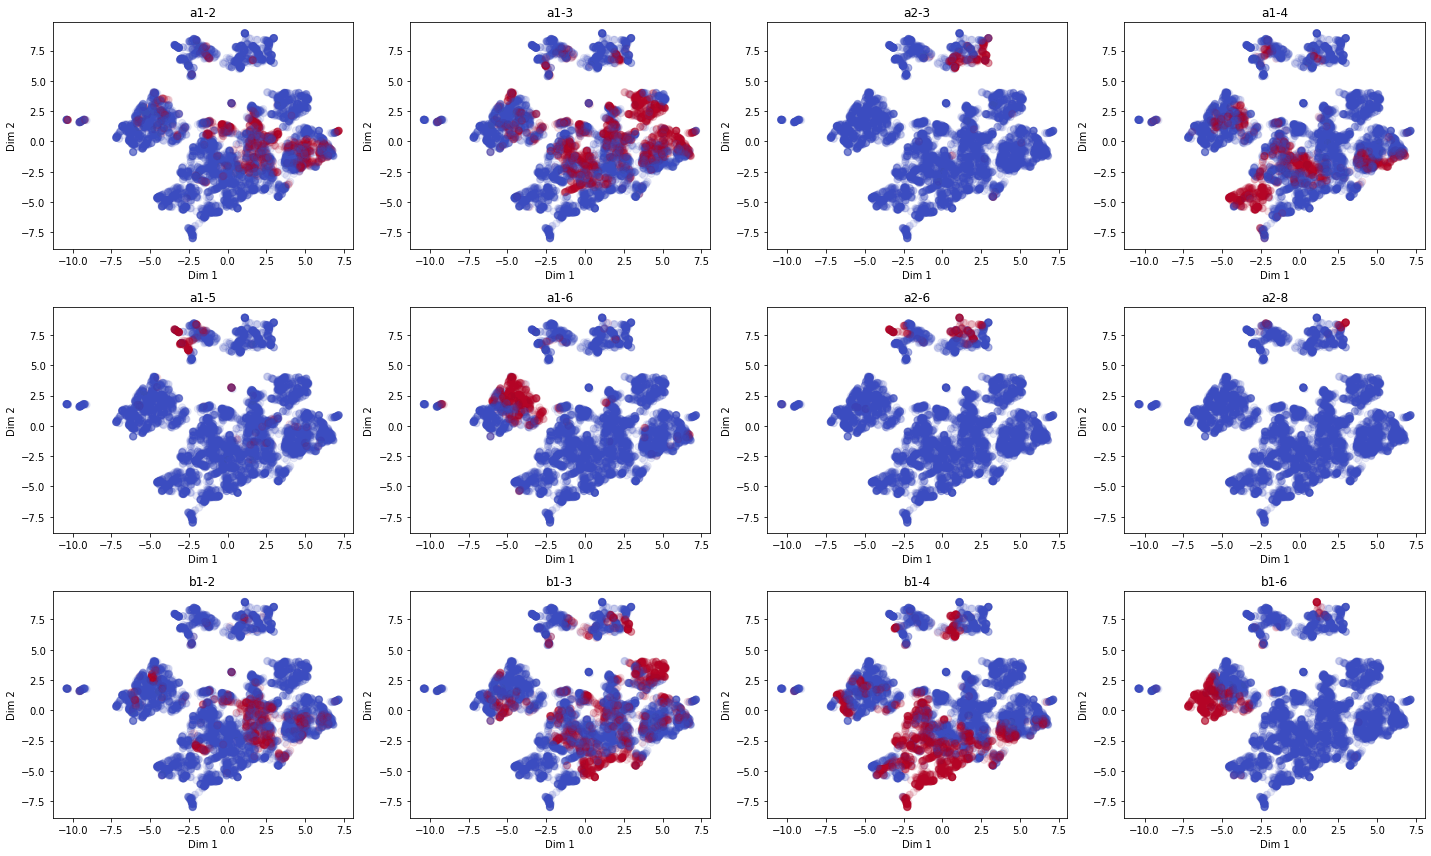

In [0]:
#replace all 'bonds' occurences with 'sugars' for visualizing monosaccharide distribution among glycowords
#every point corresponds to one observed glycoword
plt.figure(figsize = (20,12))
for i in range(len(bonds)):
  plt.subplot(3, 4, i+1)
  gals = [1 if bonds[i] in k else 0 for k in list(rep.keys())]
  plt.scatter(dim_red_emb2[:,0], dim_red_emb2[:,1], s = 50, alpha = 0.1, c = gals, cmap = 'coolwarm', rasterized = True)
  plt.xlabel('Dim 1')
  plt.ylabel('Dim 2')
  plt.title('%s' % bonds[i])
plt.tight_layout()
#plt.savefig('drive/My Drive/glycowords_by_bond_large2.svg', format = 'svg', dpi = 300)

# Analyzing Glycoword Distribution

In [0]:
#all glycosidic bonds
all_bonds = ['a1-1', 'a1-2', 'a1-3', 'a1-4', 'a1-5', 'a1-6', 'a1-7', 'a1-8',
             'a2-1', 'a2-2', 'a2-3', 'a2-4', 'a2-5', 'a2-6', 'a2-7', 'a2-8',
             'a2-9', 'b1-1', 'b1-2', 'b1-3', 'b1-4', 'b1-5', 'b1-6', 'b1-7',
             'b1-8', 'b1-9', 'b2-1', 'b2-2', 'b2-3', 'b2-4', 'b2-5', 'b2-6',
             'b2-7', 'b2-8']

#all non-glycosidic bonds are thrown out for analyses
all_sugars = [k for k in lib_all_long if k not in all_bonds]
all_sugars = [k for k in all_sugars if k not in ['', '1', '1-3', '1-4', '1-6',
                                                 '2-6', '3', '3-3', '3-5', '3-6',
                                                 '4', '5-2', '5-3', '5-6']]

def construct_glycoword(n = 100):
  """randomly constructs n glycowords (and their embeddings) from the pool of observed glycoletters"""
  out = {}
  for k in range(n):
    s1 = random.choice(all_sugars)
    s2 = random.choice(all_sugars)
    s3 = random.choice(all_sugars)
    b1 = random.choice(all_bonds)
    b2 = random.choice(all_bonds)
    idx = tuple([s1, b1, s2, b2, s3])
    tokens = string_to_labels([s1, b1, s2, b2, s3], lib_all_long)
    out[idx] = np.mean(embed[tokens, :], axis = 0)
  return out

#plots observed glycowords on top of potential, sampled glycowords
generated = construct_glycoword(n = 2000)
real_glycowords = random.sample(list(rep.values()), 100)

dim_red_emb_gen = reducer.fit_transform(pd.DataFrame.from_dict(generated).T)
dim_red_emb_gen = pd.DataFrame(dim_red_emb_gen, columns = ['dim1', 'dim2'])

real = reducer.transform(np.array(real_glycowords))
real = pd.DataFrame(real, columns = ['dim1', 'dim2'])

plt.figure(figsize = (10,6))
ax = sns.scatterplot(x = 'dim1', y = 'dim2', data = dim_red_emb_gen, s = 50, alpha = 0.01)
sns.scatterplot(x = 'dim1', y = 'dim2', data = real, s = 100, alpha = 0.1, ax = ax)
plt.show()
#ax.figure.savefig('drive/My Drive/distribution_real_generated_large_all.svg', format = 'svg', dpi = 300)

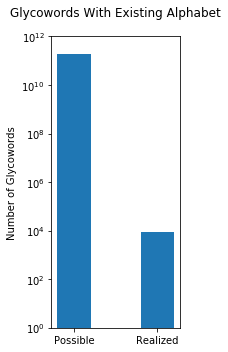

In [0]:
#calculation of all possible glycowords, given the observed glycoletters
possible = len(all_sugars)*len(all_bonds)*len(all_sugars)*len(all_bonds)*len(all_sugars)
realized = len(list(set([tuple(k) for k in df_all_long])))

plt.figure(figsize = (3,5)) 
plt.bar(['Possible', 'Realized'], [possible, realized], width = 0.4)
plt.ylabel('Number of Glycowords')
plt.yscale('log')
plt.ylim((10**0, 10**12))

plt.title('Glycowords With Existing Alphabet', pad = 20)
plt.tight_layout()
#plt.savefig('drive/My Drive/possible_realized_large.svg', format = 'svg', dpi = 300)

# Analyzing Species Distribution of Glycans

In [0]:
#get glycans labeled by species and process their glycan sequences into glycan embeddings (by averaging their glycoword embeddings)
#corresponds to Supplementary Table 6
df_species = pd.read_csv('drive/My Drive/glyco_targets_species_seq.csv')
species = df_species.species.values.tolist()
seq_species = df_species.target.values.tolist()
seq_species = process_glycans(seq_species)
seq_species = [[string_to_labels(k, lib_all_long) for k in j] for j in seq_species]
seq_species = [[np.mean(embed[k,:], axis = 0) for k in j] for j in seq_species]
seq_species = [np.mean(k, axis = 0) for k in seq_species]

In [0]:
#UMAP & t-SNE dimensionality reduction
reducer_all = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb_all = reducer_all.fit_transform(pd.DataFrame(seq_species))
tsne_emb_all = TSNE(n_components = 2).fit_transform(pd.DataFrame(seq_species))

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [0]:
#representative species to visualize glycan distribution
species_list2 = ['Homo_sapiens', 'Bos_taurus', 'Sus_scrofa', 'Oryctolagus_cuniculus',
                 'Rattus_norvegicus', 'Mus_musculus', 'Gallus_gallus', 'Bufo_bufo',
                 'Xenopus_laevis', 'Apis_mellifera', 'Drosophila_melanogaster',
                 'Arabidopsis_thaliana', 'Aspergillus_niger',
                 'Saccharomyces_cerevisiae', 'Bacteria']

plt.figure(figsize = (20,12))
for i in range(len(species_list2)):
  plt.subplot(5, 3, i+1)
  gals = [1 if k == species_list2[i] else 0 for k in species]
  gals = [bool(k) for k in gals]
  plt.scatter(tsne_emb_all[:,0], tsne_emb_all[:,1], s = 50, alpha = 0.01, c = 'blue')
  plt.scatter(tsne_emb_all[np.array(gals)][:,0], tsne_emb_all[np.array(gals)][:,1], s = 50, c = 'orange', alpha = 0.2)
  plt.xlabel('Dim 1')
  plt.ylabel('Dim 2')
  plt.title('%s' % species_list2[i])
plt.tight_layout()
#plt.savefig('drive/My Drive/species_distribution_large_tsne.svg', format = 'svg', dpi = 300)

In [0]:
#construct average embedding per species (by averaging their glycan embeddings)
avgs = []
for i in range(len(species_list2)):
  temp = [seq_species[k] for k in range(len(seq_species)) if species[k] == species_list2[i]]
  avgs.append(np.mean(temp, axis = 0))
  
#calculate cosine distance matrix
dm = pdist(np.array(avgs), 'cosine')
dm2 = squareform(dm)

In [0]:
#Code to calculate mannose fraction in glycans per species

#avgs = []
#dee = [small_motif_find(k) for k in df_species.target.values.tolist()]
#for i in range(len(species_list2)):
#  temp = [dee[k] for k in range(len(seq_species)) if species[k] == species_list2[i]]
#  temp = [k.count('Man')/((len(k.split('*'))/2)+1) for k in temp]
#  avgs.append(np.mean(temp))

In [0]:
#Code to visualize mannose fraction in glycans per species

#z = list(zip(avgs, species_list2))
#z.sort(reverse = False)
#a,b = zip(*z)
#plt.figure(figsize = (6,6))
#plt.barh(range(len(species_list2)), a)
#plt.yticks(range(len(species_list2)), b)
#plt.xlabel('Fraction of Mannose among used Monosaccharides')
#plt.tight_layout()
#plt.savefig('drive/My Drive/mannose_plot.svg', format = 'svg', dpi = 300)

In [0]:
#create linkage matrix and plot dendrogram of species given their glycan embeddings
Z = linkage(dm)
plt.figure(figsize = (10,6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Species')
dendrogram(
    Z,
    truncate_mode = 'lastp',  # show only the last p merged clusters
    orientation = 'left',
    p = 20,  # show only the last p merged clusters
    show_leaf_counts = False,  # otherwise numbers in brackets are counts
    leaf_rotation = 0.,
    labels = species_list2,
    leaf_font_size = 12.,
    show_contracted = True,  # to get a distribution impression in truncated branches
)

#plt.savefig('drive/My Drive/dendrogram_species2.svg', format = 'svg', dpi  =300, bbox_inches = 'tight')

# Prepare Dataset for Linkage Classifier

In [0]:
#get glycans with linkage information, throw away free glycans, and process the rest into glycowords
#corresponds to Supplementary Table 7
df_pan_linkage = pd.read_csv('drive/My Drive/sugar_scrape_unicarb_clean_long.csv')
df_pan_linkage = df_pan_linkage[df_pan_linkage.free != 1]
df_pan_linkage.drop(['free'], axis = 1, inplace  =True)
df_pan_linkage.seq = process_glycans(df_pan_linkage.seq.values.tolist())
df_pan_linkage.reset_index(drop = True, inplace = True)
df_pan_linkage

,seq,olink,nlink
0,"[[Fuc, a1-2, Gal, a1-3, Gal], [Gal, a1-3, Gal,...",1,0
1,"[[Fuc, a1-2, Gal, a1-3, Gal], [Gal, a1-3, Gal,...",1,0
2,"[[Fuc, a1-2, Gal, a1-3, Gal], [Gal, a1-3, Gal,...",1,0
3,"[[Fuc, a1-2, Gal, a1-3, Gal], [Gal, a1-3, Gal,...",1,0
4,"[[NeuNAc, a2-3, Gal, b1-4, GlcNAc], [Gal, b1-4...",1,0
...,...,...,...
1603,"[[Glc, a1-3, Man, a1-2, Man], [Man, a1-2, Man,...",0,1
1604,"[[Glc, a1-3, Man, a1-2, Man], [Man, a1-2, Man,...",0,1
1605,"[[Fuc, a1-3, Fuc, a1-6, GlcNAc], [Fuc, a1-6, G...",0,1
1606,"[[Fuc, a1-6, GlcNAc, b1-4, GlcNAc]]",0,1


In [0]:
#construct library of glycowords observed in this labeled dataset
lib = [item for sublist in df_pan_linkage.seq.values.tolist() for item in sublist]
lib = list(sorted(list(set(tuple(i) for i in lib))))
lib = [list(k) for k in lib]
lib_size = len(lib)

In [0]:
#use library to convert glycans into glycoword token labels
coded_glycans = [string_to_labels(k, lib) for k in df_pan_linkage.seq.values.tolist()]
df_pan_linkage['seq_coded'] = coded_glycans

In [0]:
#dataset class for linkage classifier
class SugarClassDataset(data.Dataset):
  def __init__(self, df, y):
    self.df = df
    self.y = y
    self.max_len = len(max(self.df, key = len))
    self.idx = range(len(self.df)) 
    
  def __len__(self):
    return len(self.idx)
  
  def __getitem__(self,index):
    index = self.idx[index]
    raw_string = self.df[index]
    labels = self.y[index]
    seq_length = len(raw_string)
    string_labels_padded = pad_sequence(raw_string, max_length = self.max_len, pad_label = lib_size)
    
    return (torch.LongTensor(string_labels_padded),
           torch.LongTensor([labels]),
           torch.LongTensor([seq_length]))
  
def post_process_sequence_batch(batch_tuple):
    input_seq, output_seq, seq_length = batch_tuple
    split_input_seq_batch = input_seq.split(split_size = 1)
    split_output_seq_batch = output_seq.split(split_size = 1)
    split_length_batch = seq_length.split(split_size = 1)
    
    train_data_tuples = zip(split_input_seq_batch,
                         split_output_seq_batch,
                         split_length_batch)
    sorted_train_data = sorted(train_data_tuples,
                            key = lambda p:int(p[2]),
                            reverse = True)
    split_input_batch, split_output_batch, split_length_batch = zip(*sorted_train_data)
    input_seq_sorted = torch.cat(split_input_batch)
    output_seq_sorted = torch.cat(split_output_batch)
    length_sorted = torch.cat(split_length_batch)
    
    input_seq_sorted = input_seq_sorted[:,:length_sorted[0,0]]
    output_seq_sorted = output_seq_sorted[:,:length_sorted[0,0]]
    
    input_seq_transposed = input_seq_sorted.transpose(0,1)
    
    length_sorted_list = list(length_sorted)
    length_sorted_list = list(map(lambda x: int(x), length_sorted_list))
    
    return input_seq_transposed, output_seq_sorted, length_sorted_list

#make datasets and dataloaders for linkage classifier
df_final = df_pan_linkage.copy()
df_final.drop(['seq','olink'], axis = 1, inplace = True)
train, val = train_test_split(df_final, test_size = 0.2, shuffle = True)

trainset = SugarClassDataset(train.seq_coded.values.tolist(), train.nlink.values.tolist())
trainset_loader = data.DataLoader(trainset, batch_size = 32,
                               shuffle = True, num_workers = 4)

valset = SugarClassDataset(val.seq_coded.values.tolist(), val.nlink.values.tolist())
valset_loader = data.DataLoader(valset, batch_size = 32,
                             shuffle = False)

dataloaders = {'train':trainset_loader, 'val':valset_loader}
dataset_sizes = {'train':len(train), 'val':len(val)}

# Prepare Linkage Classifier Model

In [0]:
#bidirectional, three-layered LSTM with padding. Concatenate forward & backward hidden states at the end
class linkRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, n_layers = 3):
    super(linkRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.encoder = nn.Embedding(input_size, hidden_size, padding_idx = lib_size)
    self.decoder = nn.Linear(hidden_size, num_classes)
    self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = True)
    self.logits_fc = nn.Linear(2*hidden_size, num_classes) 
    
  def forward(self, input_seq, input_seq_len, hidden = None):
    batch_size = input_seq.shape[1]
    self.bn1 = nn.BatchNorm1d(batch_size).cuda()
    embedded = self.bn1(self.encoder(input_seq))
    
    packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_seq_len)
    outputs, (h_n, c_n)=self.gru(packed, hidden)
    outputs, outputs_len = torch.nn.utils.rnn.pad_packed_sequence(outputs)

    ## last forward hidden state
    h_n_a = h_n[2,:,:]
    ## last backward hidden state
    h_n_b = h_n[3,:,:]
    h_n = torch.cat((h_n_a, h_n_b), 1)
    
    logits = self.logits_fc(h_n)
    logits = logits.transpose(0,1).contiguous()
    logits_flatten = logits.view(-1, self.num_classes)
    
    return logits_flatten, hidden

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  """training loop for classifiers"""
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  val_losses = []
  val_acc = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_acc = []
      running_metrics = []
      for batch in dataloaders[phase]:
        post_processed_batch_tuple = post_process_sequence_batch(batch)
        inputs, outputs, lengths = post_processed_batch_tuple
        inputs = inputs.cuda()
        outputs = outputs.contiguous().view(-1).float().cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred,_ = model(inputs, lengths)
          pred_acc = pred>=0.5
          loss = criterion(pred, outputs.unsqueeze(1))
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_acc.append(accuracy_score(pred_acc.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
        running_metrics.append(precision_recall_fscore_support(pred_acc.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
        
      epoch_loss = np.mean(running_loss)
      epoch_acc = np.mean(running_acc)
      epoch_metrics = np.mean(running_metrics, axis = 0)
      print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      print(epoch_metrics)
      
      if phase == 'val' and epoch_acc >= best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_acc.append(epoch_acc)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Accuracy: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  ## plot loss & acc over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of SweetTalk')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'], loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_acc)
  plt.ylabel('Validation Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation Accuracy'], loc = 'best')
  return model

In [0]:
#important to pass data for inference in masking & modification of glycans
class UnlabeledTensorDataset(data.TensorDataset):
    """Dataset wrapping unlabeled data tensors.

    Each sample will be retrieved by indexing tensors along the first
    dimension.

    Arguments:
        data_tensor (Tensor): contains sample data.
    """
    def __init__(self, data_tensor):
        self.tensors = data_tensor

    def __getitem__(self, index):
        return self.tensors[index]
    
    def __len__(self):
        return len(self.tensors)

In [0]:
#generate glycoletter token labels for relevant glycowords
words = list(sorted(list(set([tuple(string_to_labels(k, lib_all_long)) for k in lib]))))
words_label = list(sorted(list(set([tuple(k) for k in lib]))))

#construct relevant glycoword embeddings from their glycoletter embeddings
rep = {}
for k in range(len(lib)):
  rep[words_label[k]] = np.mean(embed[list(words[k]), :], axis = 0)

In [0]:
#add a padding embedding to construct initial embedding layer values
init_emb = np.array(list(rep.values()))
init_emb = np.concatenate([init_emb, np.array([0]*128).reshape(1,-1)])
init_emb.shape

(736, 128)

# SweetTalk (Linkage Classifier)

In [0]:
model2 = linkRNN(input_size = lib_size+1, hidden_size = 128,
                       num_classes = 1)                       
model2.apply(init_weights)
model2.encoder.weight.data = torch.from_numpy(init_emb).float()
model2.cuda()

early_stopping = EarlyStopping(patience = 10, verbose = True)
optimizer_ft = optim.Adam(model2.parameters(), lr = 0.00005, weight_decay = 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 50)
criterion = nn.BCEWithLogitsLoss().cuda()
#model_ft2 = train_model(model2, criterion, optimizer_ft, scheduler,
#                    num_epochs = 50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#torch.save(model_ft2, 'drive/My Drive/SweetTalk_linkageClassifier_large.pt')
model_ft2 = torch.load('drive/My Drive/SweetTalk_linkageClassifier_large.pt').eval()

# Linkage Analysis -- Masking

In [0]:
#process glycan into tokenized glycowords for masking
seq = 'GalOMe(b1-6)GalOMe(b1-3)[GalOMe(b1-6)]GalNAc(b1-4)GlcNAc(b1-2)Man(a1-3)[Man(a1-6)][Xyl(b1-2)]Man(b1-4)GlcNAc(b1-4)GlcNAc'
seq_coded = string_to_labels(process_glycans([seq])[0], lib)
seq_coded

[305, 301, 303, 285, 399, 593, 646, 733, 657]

In [0]:
#generates masked glycan variants

#removes glycowords from the end
maskpool = []
a = seq_coded
maskpool.append(a)
temp = copy.copy(seq_coded)
for i in range(len(maskpool[0])-1):
  temp[i] = len(init_emb)-1
  temp2 = copy.copy(temp)
  maskpool.append(temp2)

#removes glycowords from the front
maskpool_rv = []
a = seq_coded
maskpool_rv.append(a)
temp = copy.copy(seq_coded)
for i in range(len(maskpool_rv[0])-1, 0, -1):
  temp[i] = len(init_emb)-1
  temp2 = copy.copy(temp)
  maskpool_rv.append(temp2)

In [0]:
#dataloaders to use masked glycans for model inference
data_t = UnlabeledTensorDataset(torch.LongTensor(maskpool))
data_loader = data.DataLoader(data_t, batch_size = len(maskpool), shuffle = False, num_workers = 4, pin_memory = True)
data_t_rv = UnlabeledTensorDataset(torch.LongTensor(maskpool_rv))
data_loader_rv = data.DataLoader(data_t_rv, batch_size = len(maskpool_rv), shuffle = False, num_workers = 4, pin_memory = True)

#model inference
inputs = next(iter(data_loader))
lengths = torch.LongTensor([len(a)]+list(reversed(list(range(len(a)))))[:-1])
model_ft2.eval()
temp, _ = model_ft2(inputs.transpose(0,1).cuda(), lengths)
temp = torch.sigmoid(temp)
encoded_data = temp.cpu().detach().numpy()

inputs_rv = next(iter(data_loader_rv))
temp_rv, _ = model_ft2(inputs_rv.transpose(0,1).cuda(), lengths)
temp_rv = torch.sigmoid(temp_rv)
encoded_data_rv = temp_rv.cpu().detach().numpy()

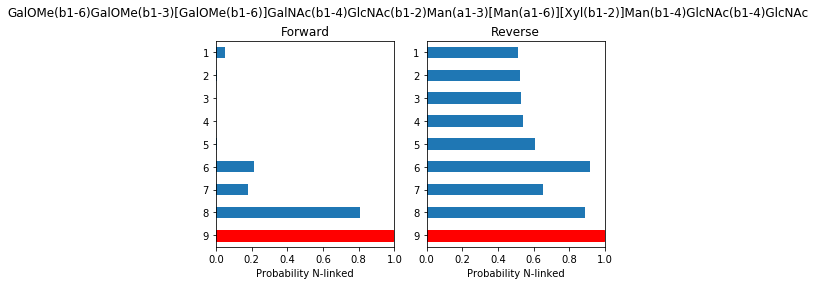

In [0]:
#plot masked glycans and their predicted linkage type
enc_data = [encoded_data_rv, encoded_data]
titles = ['Forward', 'Reverse']
plt.figure(1)
for i in range(len(enc_data)):
  plt.subplot(1, 2, i+1)
  mask_df = pd.DataFrame([k[0] for k in enc_data[i].tolist()], columns = ['res'])
  ax = mask_df.plot(ax = plt.gca(), kind = 'barh', legend = False)
  ax.get_children()[0].set_color('r')
  ax.set_xlabel('Probability N-linked')
  ax.get_yaxis().set_ticklabels(list(reversed(list(range(1, len(maskpool[0])+1)))))
  plt.title(titles[i])
  plt.xlim(0,1)
plt.suptitle(seq)
plt.tight_layout()
plt.subplots_adjust(top=0.86)
#plt.savefig('drive/My Drive/ex6_linkage_large.svg', format = 'svg', dpi = 300)

# Linkage Analysis -- Modification

(0, 1.0)

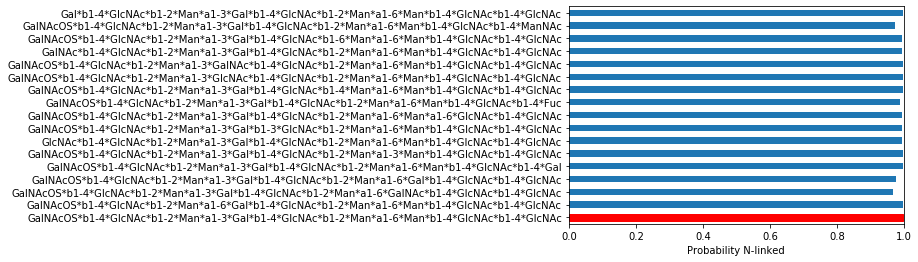

In [0]:
#randomly makes glycoletter modifications in glycans but only keeps those that lead to observed glycowords
pool, pool_labels = process_mutated_glycans('GalNAcOS(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
                                            n_mut = 1, n = 4000)
coded_pool = [string_to_labels(k, lib) if all([i in lib for i in k]) else np.nan for k in pool]
pool_df = list(zip(coded_pool, pool_labels))
pool_df = pd.DataFrame(pool_df, columns = ['seq_coded','label']).dropna().drop_duplicates(subset = 'label').reset_index(drop = True)

#use modified glycans for model inference
data_t = UnlabeledTensorDataset(torch.LongTensor(pool_df.seq_coded.values.tolist()))
data_loader = data.DataLoader(data_t, batch_size = len(pool_df.seq_coded.values.tolist()), shuffle = False,
                              num_workers = 4, pin_memory = True)

#model inference
inputs = next(iter(data_loader))
lengths = [len(inputs[0])]*len(pool_df.seq_coded.values.tolist())
model_ft2.eval()
temp, _ = model_ft2(inputs.transpose(0,1).cuda(), lengths)
temp = torch.sigmoid(temp)
encoded_data = temp.cpu().detach().numpy()
pool_df['res'] = [k[0] for k in encoded_data.tolist()]

#plot modified glycans and their predicted linkage
ax = pool_df[['label', 'res']].plot(kind = 'barh', legend = False)
ax.set_yticklabels(pool_df.label.values.tolist())
ax.get_children()[0].set_color('r')
ax.set_xlabel('Probability N-linked')
plt.xlim(0,1.0)
#plt.savefig('drive/My Drive/mut_linkage_large_ex6.svg', format = 'svg', dpi = 300, bbox_inches = 'tight')

# Visualize Glycoword/Glycan Embeddings Learned by Linkage Classifier

In [0]:
#extract learned glycoword embeddings from linkage classifier
embed2 = model_ft2.encoder.weight.data.cpu().numpy()[:-1,:]
embed2_dic = {tuple(lib[k]):embed2[k,:] for k in range(len(lib))}

#UMAP & t-SNE dimensionality reduction
reducer2 = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb2 = reducer2.fit_transform(embed2)
tsne_emb2 = TSNE(n_components = 2).fit_transform(embed2)

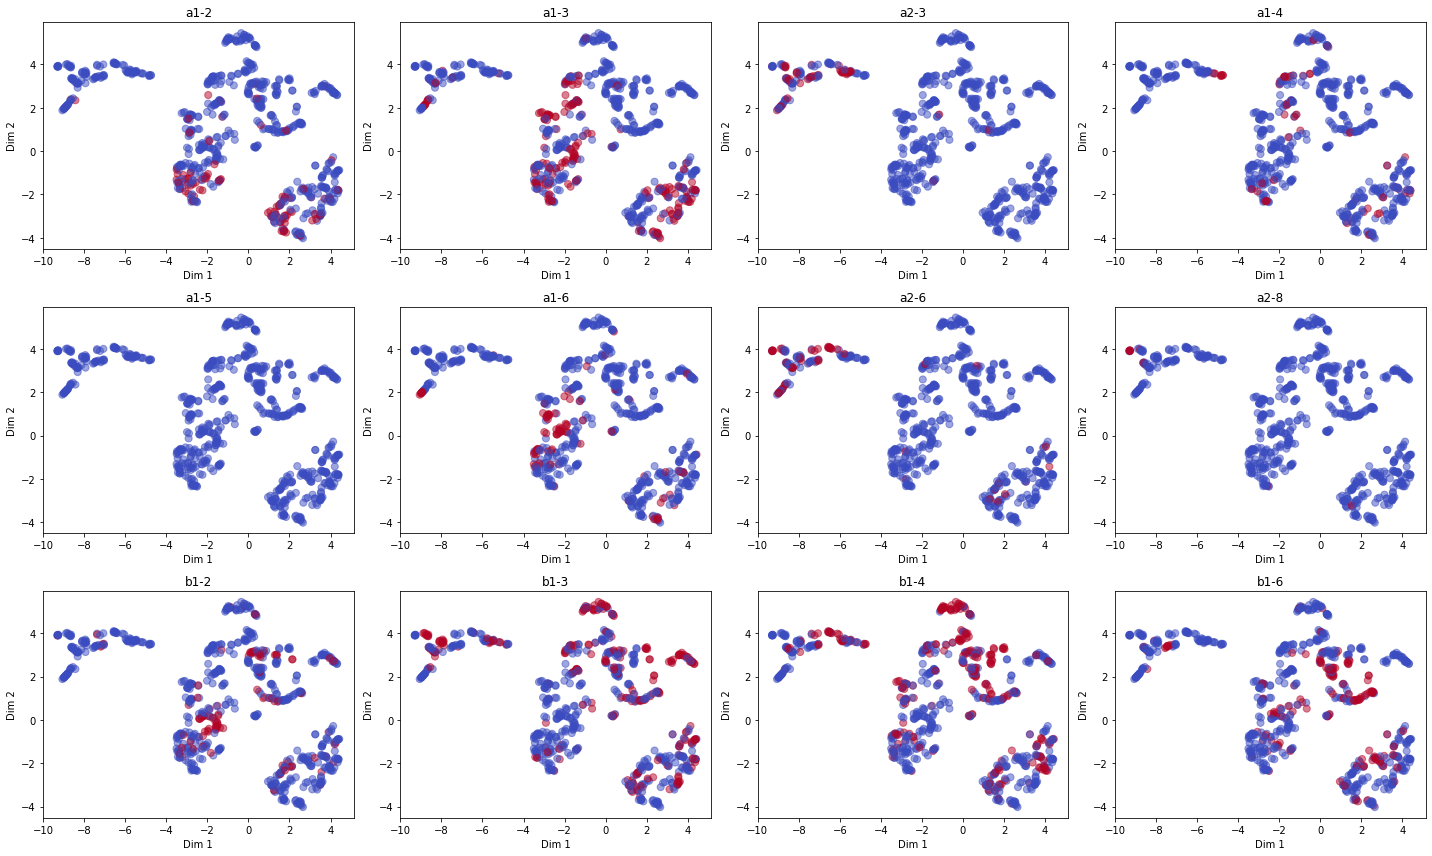

In [0]:
#plot glycowords, exchange 'bonds' with 'sugars' for visualization of monosaccharides
plt.figure(figsize = (20,12))
for i in range(len(bonds)):
  plt.subplot(3, 4, i+1)
  gals = [1 if bonds[i] in k else 0 for k in list(embed2_dic.keys())]
  plt.scatter(dim_red_emb2[:,0], dim_red_emb2[:,1], s = 50, alpha = 0.5, c = gals, cmap = 'coolwarm')
  plt.xlabel('Dim 1')
  plt.ylabel('Dim 2')
  plt.title('%s' % bonds[i])
plt.tight_layout()
#plt.savefig('drive/My Drive/glycoword_by_bonds_linkage_large.svg', format = 'svg', dpi = 300)

In [0]:
#get glycan embeddings by averaging the learned glycoword embeddings
df_pan_linkage = pd.read_csv('drive/My Drive/sugar_scrape_unicarb_clean_long.csv')[:1608]
seq_linkage = process_glycans(df_pan_linkage.seq.values.tolist())
seq_linkage = [string_to_labels(k, lib) for k in seq_linkage]
seq_linkage = [np.mean(embed2[k,:], axis = 0) for k in seq_linkage]
reducer_linkage = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb_linkage = reducer_linkage.fit_transform(seq_linkage)
tsne_emb_linkage = TSNE(n_components = 2).fit_transform(seq_linkage)

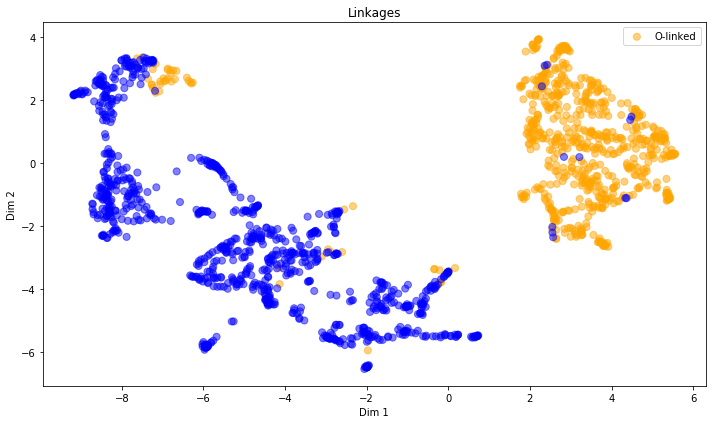

In [0]:
#plot glycan embeddings colored by linkage
plt.figure(figsize = (10,6))
gals = ['Blue' if k ==1 else 'Orange' for k in df_pan_linkage.nlink.values.tolist()]
plt.scatter(dim_red_emb_linkage[:,0], dim_red_emb_linkage[:,1], s = 50, alpha = 0.5, c = gals, rasterized = True)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Linkages')
plt.legend(['O-linked','N-linked'], loc = 'best')
plt.tight_layout()
#plt.savefig('drive/My Drive/learned_linkage_large.svg', format = 'svg', dpi = 300)

# Preparing Dataset for Immunogenicity Classifier

In [0]:
#get 685 random human glycans
df_neg = df_species[df_species['species'] == 'Homo_sapiens']
df_neg.drop(['species'], axis = 1, inplace = True)
df_neg.columns = ['seq']
df_neg = df_neg.sample(n = 685, random_state = 42)
df_neg.reset_index(drop = True, inplace = True)
df_neg['immunogenic'] = [0]*685

#get curated immunogenic glycans
#part of Supplementary Table 9
df_pos = pd.read_csv('drive/My Drive/immunogenic_glycans_clean.csv')
df_pos.drop(['name'], axis = 1, inplace = True)

#combine both into dataset
df_immuno = pd.concat([df_neg, df_pos])
df_immuno.reset_index(drop = True, inplace = True)
#df_immuno.to_csv('drive/My Drive/immuno_data.csv')
df_immuno.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,seq,immunogenic
0,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[GalOS(b1-4)GlcN...,0
1,Fuc(a1-3)[Gal(b1-4)]GlcNAcOS(b1-6)[NeuNAc(a2-3...,0
2,GalOS(b1-4)GlcNAc(b1-2)[NeuNAc(a2-3)Gal(b1-4)G...,0
3,GalNAc(b1-4)[NeuNAc(a2-3)]Gal(b1-4)GlcNAc(b1-4...,0
4,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1...,0


In [0]:
#process glycans into lists of glycowords
df_immuno.seq = process_glycans(df_immuno.seq.values.tolist())
df_immuno.reset_index(drop = True, inplace = True)
df_immuno.head()

,seq,immunogenic
0,"[[Fuc, a1-2, Gal, b1-3, GlcNAc], [Gal, b1-3, G...",0
1,"[[Fuc, a1-3, Gal, b1-4, GlcNAcOS], [Gal, b1-4,...",0
2,"[[GalOS, b1-4, GlcNAc, b1-2, NeuNAc], [GlcNAc,...",0
3,"[[GalNAc, b1-4, NeuNAc, a2-3, Gal], [NeuNAc, a...",0
4,"[[Fuc, a1-2, Gal, b1-4, GlcNAc], [Gal, b1-4, G...",0


In [0]:
#create library of observed glycowords
lib = [item for sublist in df_immuno.seq.values.tolist() for item in sublist]
lib = list(sorted(list(set(tuple(i) for i in lib))))
lib = [list(k) for k in lib]
lib_size = len(lib)

#convert list of glycowords into list of tokenized glycowords
coded_glycans = [string_to_labels(k, lib) for k in df_immuno.seq.values.tolist()]
df_immuno['seq_coded'] = coded_glycans
df_immuno.drop(['seq'], axis = 1, inplace = True)

In [0]:
#create datasets & dataloaders for model training
train, val = train_test_split(df_immuno, test_size = 0.2, shuffle = True)

trainset = SugarClassDataset(train.seq_coded.values.tolist(), train.immunogenic.values.tolist())
trainset_loader = data.DataLoader(trainset, batch_size = 32,
                               shuffle = True, num_workers = 4)

valset = SugarClassDataset(val.seq_coded.values.tolist(), val.immunogenic.values.tolist())
valset_loader = data.DataLoader(valset, batch_size = 32,
                             shuffle = False)

dataloaders = {'train':trainset_loader, 'val':valset_loader}
dataset_sizes = {'train':len(train), 'val':len(val)}

In [0]:
#create tokens for observed glycoletters
words = list(sorted(list(set([tuple(string_to_labels(k, lib_all_long)) for k in lib]))))
words_label = list(sorted(list(set([tuple(k) for k in lib]))))

#create embeddings for relevant glycowords by averaging their glycoletter embeddings
rep = {}
for k in range(len(lib)):
  rep[words_label[k]] = np.mean(embed[list(words[k]), :], axis = 0)

In [0]:
#add padding embedding and construct initial embedding layer values
init_emb = np.array(list(rep.values()))
init_emb = np.concatenate([init_emb,np.array([0]*128).reshape(1,-1)])
init_emb.shape

(1775, 128)

# Preparing for Model Training

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience = 7, verbose = False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation acc increased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #torch.save(model.state_dict(), 'drive/My Drive/checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  """training loop for immunogenicity classifier"""
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  val_losses = []
  val_acc = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_acc = []
      running_metrics = []
      for batch in dataloaders[phase]:
        post_processed_batch_tuple = post_process_sequence_batch(batch)
        inputs, outputs, lengths = post_processed_batch_tuple
        inputs = inputs.cuda()
        outputs = outputs.contiguous().view(-1).float().cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred,_ = model(inputs, lengths)
          pred_acc = pred>=0.5
          loss = criterion(pred, outputs.unsqueeze(1))
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_acc.append(accuracy_score(pred_acc.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
        running_metrics.append(precision_recall_fscore_support(pred_acc.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
        
      epoch_loss = np.mean(running_loss)
      epoch_acc = np.mean(running_acc)
      epoch_metrics = np.mean(running_metrics, axis=0)
      print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      print(epoch_metrics)
      
      if phase == 'val' and epoch_acc >= best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_acc.append(epoch_acc)
        early_stopping(epoch_acc, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Accuracy: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  ## plot loss & acc over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of SweetTalk')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'], loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_acc)
  plt.ylabel('Validation Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation Accuracy'], loc = 'best')
  return model

# SweetTalk (Immunogenicity Classifier)

In [0]:
model3 = linkRNN(input_size = lib_size+1, hidden_size = 128,
                       num_classes = 1)                       
model3.apply(init_weights)
model3.encoder.weight.data = torch.from_numpy(init_emb).float()
model3.cuda()

early_stopping = EarlyStopping(patience = 20, verbose = True)
optimizer_ft = optim.Adam(model3.parameters(), lr = 0.00005, weight_decay = 5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 150)
criterion = nn.BCEWithLogitsLoss().cuda()
#model_ft3 = train_model(model3, criterion, optimizer_ft, scheduler,
#                    num_epochs = 150)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#torch.save(model_ft3, 'drive/My Drive/SweetTalk_immunoClassifier_large.pt')
model_ft3 = torch.load('drive/My Drive/SweetTalk_immunoClassifier_large.pt').eval()

# Visualizing Glycoword Embeddings Learned by Immunogenicity Classifier

In [0]:
#extract learned glycoword embeddings from immunogenicity classifier
embed3 = model_ft3.encoder.weight.data.cpu().numpy()[:len(lib),:]
embed3_dic = {tuple(lib[k]):embed3[k,:] for k in range(len(lib))}

#UMAP & t-SNE dimensionality reduction
reducer3 = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb3 = reducer3.fit_transform(embed3)
tsne_emb3 = TSNE(n_components = 2).fit_transform(embed3)

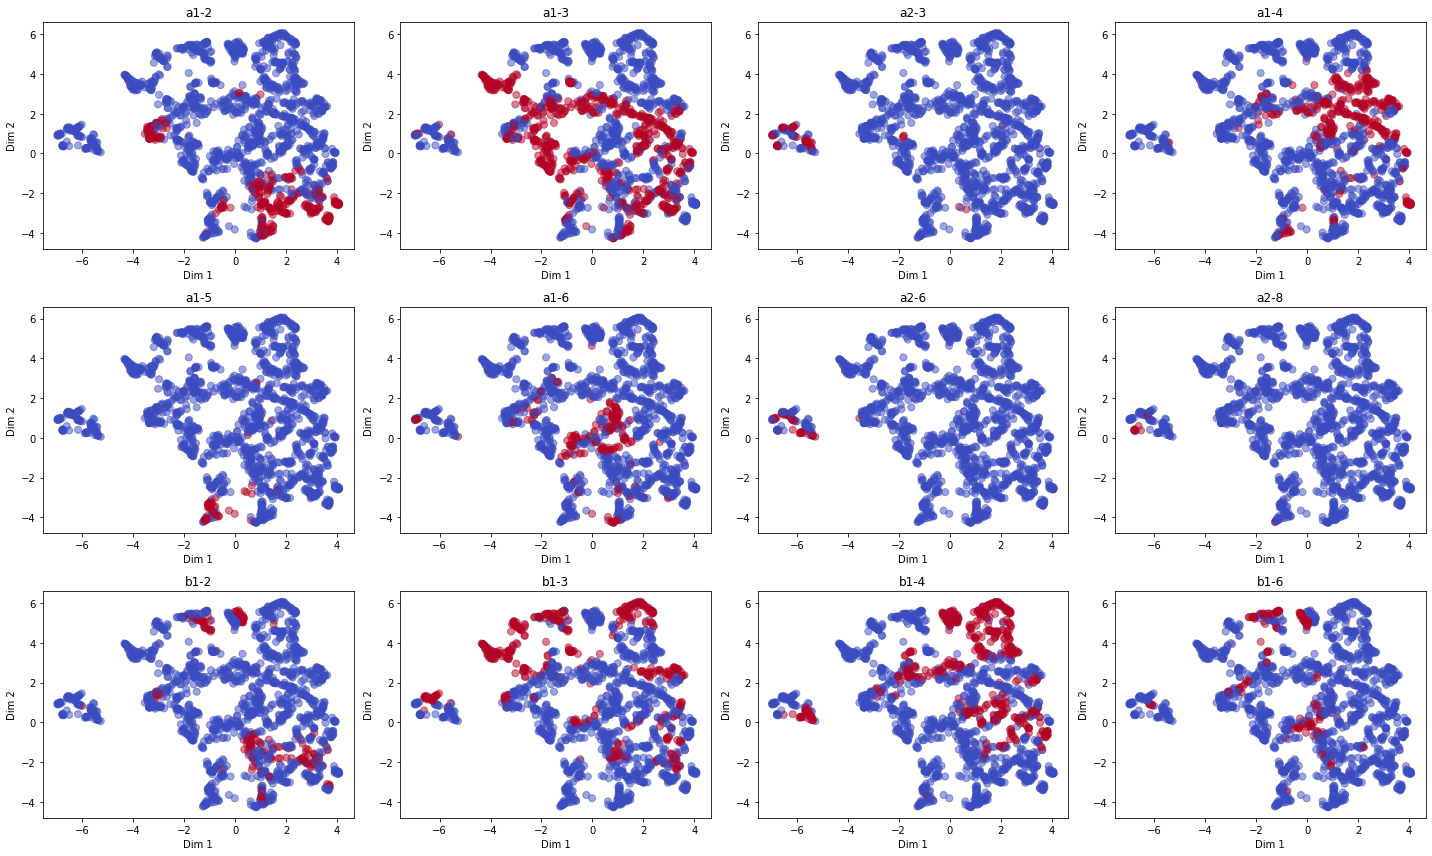

In [0]:
#plot learned glycoword embeddings, replace 'bonds' with 'sugars' to visualize monosaccharides
plt.figure(figsize = (20,12))
for i in range(len(bonds)):
  plt.subplot(3, 4, i+1)
  gals = [1 if bonds[i] in k else 0 for k in list(embed3_dic.keys())]
  plt.scatter(dim_red_emb3[:,0], dim_red_emb3[:,1], s = 50, alpha = 0.5, c = gals, cmap = 'coolwarm')
  plt.xlabel('Dim 1')
  plt.ylabel('Dim 2')
  plt.title('%s' % bonds[i])
plt.tight_layout()
#plt.savefig('drive/My Drive/glycowords_by_bond_immuno_large.svg', format = 'svg', dpi = 300)

# Helper Function: Using Foreign Glycans for Model Inference

In [0]:
def string_to_labels_flex(seq, libr):
  """constructs list of tokenized glycowords for glycan, either from library or by finding closest observed glycowords"""
  out = []
  for i in range(len(seq)):
    if seq[i] in libr:
      out.append(character_to_label(seq[i], libr))
    else:
      temp = string_to_labels(seq[i], lib_all_long)
      temp = np.mean(embed[temp,:], axis = 0)
      temp_cos = cosine_similarity(temp.reshape(1,-1), embed3).tolist()
      temp_cos = lib[np.argmax(temp_cos)]
      out.append(character_to_label(temp_cos, libr))
  return out

# Immunogenicity Analysis -- Masking

In [0]:
#choose and process glycan sequence for masking analysis
seq = '[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[GalOS(b1-4)GlcNAc(b1-6)]GalNAc'
seq_coded = string_to_labels(process_glycans([seq])[0], lib)
#seq = 'Rha(a1-2)Rha(a1-3)[Glc(a1-6)Glc(a1-2)]Rha(a1-3)Rha'
#seq_coded = string_to_labels_flex(process_glycans([seq])[0], lib)

#masks glycowords from the end
maskpool = []
a = seq_coded
maskpool.append(a)
temp = copy.copy(seq_coded)
for i in range(len(maskpool[0])-1):
  temp[i] = len(init_emb)-1
  temp2 = copy.copy(temp)
  maskpool.append(temp2)

#masks glycowords from the front
maskpool_rv = []
a = seq_coded
maskpool_rv.append(a)
temp = copy.copy(seq_coded)
for i in range(len(maskpool_rv[0])-1, 0, -1):
  temp[i] = len(init_emb)-1
  temp2 = copy.copy(temp)
  maskpool_rv.append(temp2)

In [0]:
#prepare dataloaders for model inference
data_t = UnlabeledTensorDataset(torch.LongTensor(maskpool))
data_loader = data.DataLoader(data_t, batch_size = len(maskpool), shuffle = False, num_workers = 4, pin_memory = True)
data_t_rv = UnlabeledTensorDataset(torch.LongTensor(maskpool_rv))
data_loader_rv = data.DataLoader(data_t_rv, batch_size = len(maskpool_rv), shuffle = False, num_workers = 4, pin_memory = True)

#model inference
inputs = next(iter(data_loader))
lengths = torch.LongTensor([len(a)]+list(reversed(list(range(len(a)))))[:-1])
model_ft3.eval()
temp, _ = model_ft3(inputs.transpose(0,1).cuda(), lengths)
temp = torch.sigmoid(temp)
encoded_data = temp.cpu().detach().numpy()

inputs_rv = next(iter(data_loader_rv))
temp_rv, _ = model_ft3(inputs_rv.transpose(0,1).cuda(), lengths)
temp_rv = torch.sigmoid(temp_rv)
encoded_data_rv = temp_rv.cpu().detach().numpy()

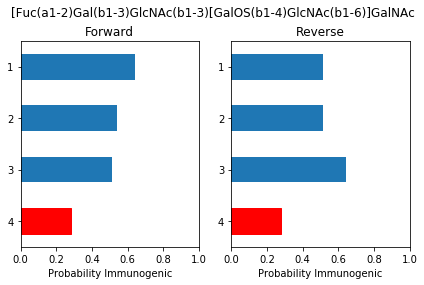

In [0]:
#plot masked glycans and their predicted immunogenicity
enc_data = [encoded_data_rv, encoded_data]
titles = ['Forward', 'Reverse']
plt.figure(1)
for i in range(len(enc_data)):
  plt.subplot(1, 2, i+1)
  mask_df = pd.DataFrame([k[0] for k in enc_data[i].tolist()], columns = ['res'])
  ax = mask_df.plot(ax = plt.gca(), kind = 'barh', legend = False)
  ax.get_children()[0].set_color('r')
  ax.set_xlabel('Probability Immunogenic')
  ax.get_yaxis().set_ticklabels(list(reversed(list(range(1,len(maskpool[0])+1)))))
  plt.title(titles[i])
  plt.xlim(0,1)
plt.suptitle(seq)
plt.tight_layout()
plt.subplots_adjust(top = 0.86)
#plt.savefig('drive/My Drive/mask_ex6_immuno_large.svg', format = 'svg', dpi = 300)

# Immunogenicity Analysis -- Modification

(0, 1.0)

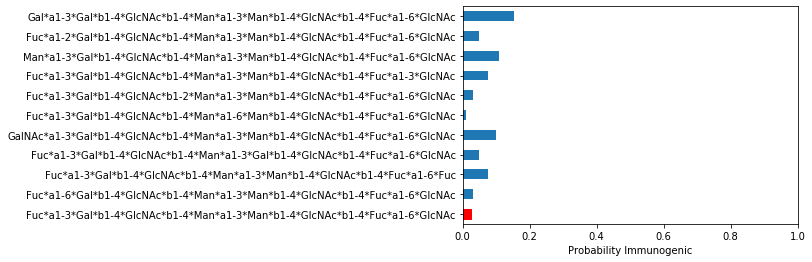

In [0]:
#randomly mutate glycans and only keep modifications which result in observed glycowords
pool, pool_labels = process_mutated_glycans('Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-4)Man(a1-3)Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc',
                                            n_mut = 1, n = 4000)
coded_pool = [string_to_labels_flex(k, lib) if all([i in lib for i in k]) else np.nan for k in pool]
pool_df = list(zip(coded_pool, pool_labels))
pool_df = pd.DataFrame(pool_df, columns=['seq_coded', 'label']).dropna().drop_duplicates(subset = 'label').reset_index(drop = True)

#prepare dataloader for inference
data_t = UnlabeledTensorDataset(torch.LongTensor(pool_df.seq_coded.values.tolist()))
data_loader = data.DataLoader(data_t, batch_size = len(pool_df.seq_coded.values.tolist()),
                              shuffle = False, num_workers = 4, pin_memory = True)

#model inference
inputs = next(iter(data_loader))
lengths = [len(inputs[0])]*len(pool_df.seq_coded.values.tolist())
model_ft3.eval()
temp, _ = model_ft3(inputs.transpose(0,1).cuda(), lengths)
temp = torch.sigmoid(temp)
encoded_data = temp.cpu().detach().numpy()
pool_df['res'] = [k[0] for k in encoded_data.tolist()]

#plot modified glycans and their predicted immunogenicity
ax = pool_df[['label','res']].plot(kind = 'barh', legend = False)
ax.set_yticklabels(pool_df.label.values.tolist())
ax.get_children()[0].set_color('r')
ax.set_xlabel('Probability Immunogenic')
plt.xlim(0,1.0)
#plt.savefig('drive/My Drive/mut_immuno_aGal_large.svg', format = 'svg', dpi = 300, bbox_inches = 'tight')

# Inferring Immunogenicity of Porcine Glycans for Xenotransplantation

In [0]:
sus_data_init = sorted(df_species[df_species.species == 'Sus_scrofa'].target.values.tolist(), key = len, reverse = True)
sus_data = process_glycans(sus_data_init)
sus_data = [string_to_labels_flex(k, lib) for k in sus_data]
sus_data = [pad_sequence(k, max_length = 15, pad_label = len(lib)) for k in sus_data]

data_t = UnlabeledTensorDataset(torch.LongTensor(sus_data))
data_loader = data.DataLoader(data_t, batch_size = len(sus_data), shuffle = False, num_workers = 4, pin_memory = True)
inputs = next(iter(data_loader))
model_ft3.eval()

temp, _ = model_ft3(inputs.transpose(0,1).cuda(), [15]*len(sus_data))
temp = torch.sigmoid(temp)
encoded_data = temp.cpu().detach().numpy()
out = list(zip(sus_data_init, encoded_data))
out = pd.DataFrame(out, columns = ['seq','imm'])
#out.sort_values(by = ['imm']).to_csv('drive/My Drive/sus_scrofa_imm.csv')

# Visualize Glycan Embeddings Learned by Immunogenicity Classifier

In [0]:
#generate glycan embeddings by averaging their glycoword embeddings
seq_immuno = [np.mean(embed3[k,:], axis = 0) for k in df_immuno.seq_coded.values.tolist()]

#UMAP & t-SNE dimensionality reduction
reducer_imm = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb_imm = reducer_imm.fit_transform(seq_immuno)
tsne_emb_imm = TSNE(n_components = 2).fit_transform(seq_immuno)

In [0]:
#plot glycan embeddings and color by immunogenicity label
plt.figure(figsize = (10,6))
gals = ['Blue' if k ==1 else 'Orange' for k in df_immuno.immunogenic.values.tolist()]
plt.scatter(dim_red_emb_imm[:,0], dim_red_emb_imm[:,1], s = 50,
            alpha = 0.5, c = gals, rasterized = True)
#plt.scatter(dim_red_emb_imm[:,0], dim_red_emb_imm[:,1], s = 50,
#            alpha = 0.5, c = range(len(seq_immuno)), cmap = 'coolwarm', rasterized = True)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Immunogenicity')
plt.legend(['Nonimmunogenic', 'Immunogenic'], loc = 'best')
plt.tight_layout()
#plt.savefig('drive/My Drive/learned_immuno_large.svg', format = 'svg', dpi = 300)